In [1]:
# -*- coding: utf-8 -*-
"""
Titulo: Automatizacion reportes regionales
Created on Thu Aug 22 11:58:39 2019

Proceso que automatiza reportes regionales, generando un documento word por cada region.

Obs: Se deben revisar los inputs antes de correr

@author: hugo.gallardo
"""

# =============================================================================
# Extracción en python de datos de comunicado de compras a nivel regional
# =============================================================================

#Seteo de librerias

import pandas as pd
import numpy as np
import sqlalchemy as sa              #Para conexión a BD, requerido para usar pd.read_sql()
import urllib                        #Para formatear string de conexión

import docx
import matplotlib.pyplot as plt 
import matplotlib.patches as mpatches
import openpyxl as opxl             #para importar excel como dataframe

from docx import Document
from docx import shared
from docx.shared import Inches
from docx.enum.text import WD_ALIGN_PARAGRAPH
from docx.enum.text import WD_LINE_SPACING
from docxtpl import DocxTemplate, InlineImage   #rellenar templates

import seaborn as sns
import os
import sys
from pylab import savefig
import itertools

import pyodbc                               ### another engine to make DB connection and run the queries. Alternative to sqlalchemy
from itertools import repeat
import querysGR as qg

In [2]:
#Transforma codigo a word
#Agregar github


#Conexion a DW

#param = urllib.parse.quote_plus("DRIVER={SQL Server};SERVER=10.34.71.202;UID=datawarehouse;PWD=datawarehouse;DATABASE=DM_Transaccional")#;Trusted_Connection=yes
#conn = sa.create_engine("mssql+pyodbc:///?odbc_connect=%s" % param)

#param = urllib.parse.quote_plus("DRIVER={SQL Server};SERVER=10.34.71.227;UID=eymetric;PWD=Eym3tr1c.2022;DATABASE=DM_Transaccional_2022")#;Trusted_Connection=yes
#conn = sa.create_engine("mssql+pyodbc:///?odbc_connect=%s" % param)

#A DCCPProcurement
#paramAQ = urllib.parse.quote_plus("DRIVER={ODBC Driver 13 for SQL Server};DATABASE=DCCPProcurement;SERVER=10.34.71.145;UID=datawarehouse;PWD=datawarehouse")
#bd = sa.create_engine("mssql+pyodbc:///?odbc_connect=%s" % paramAQ)
#paramAQ = urllib.parse.quote_plus("DRIVER={ODBC Driver 13 for SQL Server};SERVER=10.34.71.146;UID=datawarehouse;PWD=datawarehouse")
#bd = sa.create_engine("mssql+pyodbc:///?odbc_connect=%s" % paramAQ)


#**** BBDD *****

# Verificar Drivers

###### DW ######

param_DW = urllib.parse.quote_plus("DRIVER={SQL Server};SERVER=10.34.71.202;UID=datawarehouse;PWD=datawarehouse;DATABASE=DM_Transaccional;TrustServerCertificate=yes")
conn_DW = sa.create_engine("mssql+pyodbc:///?odbc_connect=%s" % param_DW)


##### DEV #####

param_dev = urllib.parse.quote_plus("DRIVER={/opt/microsoft/msodbcsql18/lib64/libmsodbcsql-18.2.so.2.1};SERVER=10.34.71.227;UID=eymetric;PWD=Eym3tr1c.2022;DATABASE=DM_Transaccional_2022;TrustServerCertificate=yes")
conn_dev = sa.create_engine("mssql+pyodbc:///?odbc_connect=%s" % param_dev)

##### AQUILES #####

param_AQ = urllib.parse.quote_plus("DRIVER={SQL Server};DATABASE=DCCPProcurement;SERVER=10.34.71.146;UID=datawarehouse;PWD=datawarehouse;DATABASE=DCCPProcurement;TrustServerCertificate=yes")
conn_AQ = sa.create_engine("mssql+pyodbc:///?odbc_connect=%s" % param_AQ)

### connections with pyodbc ###
conn_AQ_pyodbc=pyodbc.connect('DRIVER={SQL Server};DATABASE=DCCPProcurement;SERVER=10.34.71.146;UID=datawarehouse;PWD=datawarehouse;DATABASE=DCCPProcurement;TrustServerCertificate=yes')#;Encrypt=yes')#;TrustServerCertificate=yes')#;TrustServerCertificate=yes')
#conn_AQ_pyodbc = pyodbc.connect('DRIVER={SQL Server};SERVER=10.34.71.146;DATABASE=DCCPProcurement;UID=datawarehouse;PWD=datawarehouse')
cursor=conn_AQ_pyodbc.cursor()
#*************************

In [3]:
# =============================================================================
# Creando parametros y funciones para queries 
# =============================================================================


#url = "C:/Users/luis.recabarren/Documents/proyecto_statistics_tool/output/"
#url='/mnt/c/Users/luis.recabarren/Documents/proyecto_statistics_tool/output/'
#url = 'C:/Users/USER/OneDrive - DCCP/Documents/comunicaciones dpto/Reporte_cifras_MP_automatizado'
url = 'C:/o/OneDrive - DCCP/Escritorio/Dpt Comunicaciones/Reportes Automatizados'
#os.chdir(url)
AnoReg = 2023

#Funcion para reducir un Anio
def Anomenos1(Ano):
    Menos = Ano - 1
    return Menos

#Funcion para poner puntos separadores de miles
def itanum(x):
    return format(int(round(x)),',d').replace(",",".")

#Funcion para poner coma a decimales
#Pensado para generador de Nov-2023
def flonum(x):
    return format(x,',').replace(".",",")    

#Transforma una tasa en un string de porcentage con un decimal
def pctaje(x):
    #format(x,',').replace(".",",")
    #return str(round(x, 1))+'%'
    x = str(round(x, 1))+'%'
    return format(x,'s').replace(".",",")

def cambiar_fuente_global(documento, nueva_fuente):
    # Crear un nuevo estilo personalizado
    nuevo_estilo = documento.styles.add_style('NuevoEstilo', 1)

    # Establecer la nueva fuente en el estilo
    nuevo_estilo.font.name = nueva_fuente

    # Aplicar el nuevo estilo a todos los párrafos en el documento
    for p in documento.paragraphs:
        p.style = nuevo_estilo

#Agrega gráfico de torta, necesita datos, etiqueta y título
def graf_torta(x, labels, titGraf): 
    plt.clf()
    #plt.figure(figsize=(4.5,4.5))
    bordeG = {'linewidth' : 1, 'edgecolor' : 'white'}
    plt.pie(x
            , autopct='%.1f%%'
            , textprops=dict(color="grey", size=7.7)
            , pctdistance=1.15
            , wedgeprops = bordeG)
    legend = plt.legend(labels
                        , loc = "lower center"
                        , bbox_to_anchor=(0.27, -0.15, 0.5, 0.5)
                        , ncols = 3
                        , fontsize=7
                        , handlelength=0.7
                        , handleheight=0.7
                        ) 
    tituloG = plt.title("Montos transados por sector " + titGraf ,fontweight="bold",fontsize=16)
    
    plt.savefig(titGraf+'.png')

AnoRegM1 = Anomenos1(AnoReg)

#Si es semestral, agregar meses correspondientes
MesInferior = 1
MesSuperior = 8

#Agregar que semestre es:
Sem = "primer"
tri='primer' #'segundo' ,etc

FechaQ = pd.Series([AnoReg,AnoRegM1, MesInferior,MesSuperior])

# =============================================================================
# Fin Inputs
# =============================================================================

In [4]:
########################
### Total  Proveedor ###
########################

FechaTotProv =  FechaQ.drop(FechaQ.index[1])
print('Tamaño proveedor (nacional). Inputs:\n')
print(FechaTotProv)
print()

QueryTotalProv = pd.read_sql(con = conn_DW,  sql = 
        '''SELECT       
				case 
					when a.idTamano is not null then 
						case a.idTamano when 1 then 'Grande'
						else 'Mipyme' end
				else 
					case isnull(b.Tamano,5) 
						when 1 then 'Grande'
						else 'Mipyme' end end Tamano

			,SUM(OC.MontoUSD+OC.ImpuestoUSD) 'MONTOUSD'
		   , SUM(OC.MontoCLF+OC.ImpuestoCLF) 'MONTOCLF'
		   ,SUM(OC.MontoCLP+OC.ImpuestoCLP) 'MONTOCLP'
			  ,count(distinct oc.porid) CantOC
               ,COUNT(DISTINCT P.RUTSucursal) 'CantProveedores'
			--  into #aux1
     FROM  
    DM_Transaccional..THOrdenesCompra AS OC     
    inner JOIN DM_Transaccional..DimTiempo AS TPO                     ON OC.IDFechaEnvioOC=TPO.DateKey 
	inner join [DM_Transaccional].[dbo].[dimproveedor] p on p.orgCode=oc.IDSucursal
    left join   [DM_Transaccional].[dbo].[THTamanoProveedor] a on a.entcode=p.entCode and AñoTributario=2021
    left join Estudios.dbo.TamanoProveedorNuevos20230809 b on p.entcode=b.entCode
    WHERE   TPO.YEAR in (2023) and TPO.MONTH >= 1 AND TPO.MONTH <= 8
	group by case 
					when a.idTamano is not null then 
						case a.idTamano when 1 then 'Grande'
						else 'Mipyme' end
				else 
					case isnull(b.Tamano,5) 
						when 1 then 'Grande'
						else 'Mipyme' end end    
                             ''')
print(QueryTotalProv)
print()
print('--------------------------------------------------------------------------------------------------------------------------------------------------------------------')
print()
#sys.exit()

Tamaño proveedor (nacional). Inputs:

0    2023
2       1
3       8
dtype: int64

   Tamano      MONTOUSD      MONTOCLF      MONTOCLP  CantOC  CantProveedores
0  Grande  6.784433e+09  1.541184e+08  5.509336e+12  547888             2555
1  Mipyme  4.206058e+09  9.565116e+07  3.421096e+12  732378            63498

--------------------------------------------------------------------------------------------------------------------------------------------------------------------



In [5]:
##################################
### Query top 10 OC por region ###
##################################

FechaQTop10 = FechaQ.drop(FechaQ.index[1])
print('Top 10 OC por region','Inputs:\n')
print(FechaQTop10)
print()

QTop10 = pd.read_sql(con = conn_DW,  sql = ''' 
SELECT *
    FROM (
        SELECT 
                case 
					when a.idTamano is not null then 
						case a.idTamano when 1 then 'Grande'
						else 'Mipyme' end
				else 
					case isnull(b.Tamano,5) 
						when 1 then 'Grande'
						else 'Mipyme' end end Tamano,
    DM_Transaccional.dbo.DimInstitucion.NombreInstitucion,
    DM_Transaccional.dbo.DimComprador.NombreUnidaddeCompra,
    DM_Transaccional.dbo.DimLocalidad.Region,
    DM_Transaccional.dbo.DimProveedor.NombreSucursal,
    --DM_Transaccional.dbo.DimTamanoProveedor.Tamano,
    DM_Transaccional.dbo.THOrdenesCompra.CodigoOC,
    DM_Transaccional.dbo.THOrdenesCompra.NombreOC,
    DM_Transaccional.dbo.THOportunidadesNegocio.NombreAdq as NombreLic,
    ISNULL(DM_Transaccional.dbo.THOportunidadesNegocio.NombreAdq, DM_Transaccional.dbo.THOrdenesCompra.NombreOC) as MotivoCompra,
    round(DM_Transaccional.dbo.THOrdenesCompra.MontoUSD + DM_Transaccional.dbo.THOrdenesCompra.ImpuestoUSD,0) USD_BRUTO,
    DM_Transaccional.dbo.THOrdenesCompra.MontoCLP + DM_Transaccional.dbo.THOrdenesCompra.ImpuestoCLP PESOS_BRUTO, Rank()
          over (Partition BY DM_Transaccional.dbo.DimLocalidad.Region
                ORDER BY DM_Transaccional.dbo.THOrdenesCompra.MontoUSD DESC ) AS Rank
                FROM DM_Transaccional.dbo.DimInstitucion INNER JOIN
             DM_Transaccional.dbo.DimComprador ON DM_Transaccional.dbo.DimInstitucion.entCode = DM_Transaccional.dbo.DimComprador.entCode INNER JOIN
             DM_Transaccional.dbo.DimLocalidad ON DM_Transaccional.dbo.DimComprador.IDLocalidadUnidaddeCompra = DM_Transaccional.dbo.DimLocalidad.IDLocalidad INNER JOIN
             DM_Transaccional.dbo.THOrdenesCompra ON DM_Transaccional.dbo.DimComprador.IDUnidaddeCompra = DM_Transaccional.dbo.THOrdenesCompra.IDUnidaddeCompra INNER JOIN
             DM_Transaccional.dbo.DimProveedor ON DM_Transaccional.dbo.DimProveedor.IDSucursal = DM_Transaccional.dbo.THOrdenesCompra.IDSucursal INNER JOIN
             --DM_Transaccional.dbo.DimTamanoProveedor ON DM_Transaccional.dbo.DimTamanoProveedor.IdTamano = DM_Transaccional.dbo.DimProveedor.IdTamano INNER JOIN
             DM_Transaccional.dbo.DimTiempo ON DM_Transaccional.dbo.DimTiempo.DateKey =  DM_Transaccional.dbo.THOrdenesCompra.IDFechaEnvioOC LEFT JOIN
             DM_Transaccional.dbo.THOportunidadesNegocio ON DM_Transaccional.dbo.THOportunidadesNegocio.rbhCode = DM_Transaccional.dbo.THOrdenesCompra.rbhCode
             left join   [DM_Transaccional].[dbo].[THTamanoProveedor] a on a.entcode=[DM_Transaccional].[dbo].[dimproveedor].entCode and AñoTributario=2021
             left join Estudios.dbo.TamanoProveedorNuevos20230809 b on [DM_Transaccional].[dbo].[dimproveedor].entcode=b.entCode
          where DM_Transaccional.dbo.dimtiempo.Year = 2023
             and DM_Transaccional.dbo.dimtiempo.month between 1 and 8
        ) rs WHERE Rank <= 3 ORDER BY Region ASC, Rank ASC
                ''')


print(QTop10)
print()
print('--------------------------------------------------------------------------------------------------------------------------------------------------------------------')
print()
#sys.exit()


Top 10 OC por region Inputs:

0    2023
2       1
3       8
dtype: int64

    Tamano                                  NombreInstitucion  \
0   Grande      SERVICIO DE VIVIENDA Y URBANIZACION II REGION   
1   Grande      SERVICIO DE VIVIENDA Y URBANIZACION II REGION   
2   Grande                        MOP - Dirección de Vialidad   
3   Grande  MINISTERIO DE OBRAS PUBLICAS DIREC CION GRAL D...   
4   Grande                        MOP - Dirección de Vialidad   
5   Grande                        MOP - Dirección de Vialidad   
6   Grande                           I MUNICIPALIDAD DE ARICA   
7   Mipyme            SERVICIO DE SALUD DE ARICA Y PARINACOTA   
8   Grande                           I MUNICIPALIDAD DE ARICA   
9   Grande                          Servicio de Salud Atacama   
10  Grande                          Servicio de Salud Atacama   
11  Grande  MINISTERIO DE OBRAS PUBLICAS DIREC CION GRAL D...   
12  Grande                        MOP - Dirección de Vialidad   
13  Grande      

In [6]:
###########################################################################
### Query para obtener número total de proveedores que participan en MP ###
###########################################################################

##Calculando fecha para query dinamica
FechaProv =  FechaQ.drop(FechaQ.index[1])
##Proveedores solo transando
print('Proveedores transando en MP.','Inputs:\n')
print(FechaProv)
print()
#vec=['2023','1','6'] ### vector de parametros para usar con con=conn_AQ_pyodbc

QProvTrans = pd.read_sql(con = conn_AQ,  sql = '''
SELECT DISTINCT C.entCode AS Transan
FROM         
DCCPProcurement..prcPOHeader A with(nolock)INNER JOIN
DCCPPlatform..gblOrganization B with(nolock) ON A.porSellerOrganization = B.orgCode INNER JOIN
DCCPPlatform..gblEnterprise C with(nolock) ON B.orgEnterprise = C.entCode
WHERE     (A.porBuyerStatus IN (4, 5, 6, 7, 12)) 
AND year(A.porSendDate) =  2023 
and (month(A.porSendDate)>=1 AND month(A.porSendDate)<= 8 )
''')
print(QProvTrans)
print()
print('--------------------------------------------------------------------------------------------------------------------------------------------------------------------')
print()
#sys.exit()

#FechaProv2=pd.concat([FechaProv],ignore_index=True) #,FechaProv,FechaProv,FechaProv], ignore_index=True) # For conn_AQ connection using
#print()
#
#vec2=[] # vector de parametros para conn_AQ_pyodbc
#for k in range(1):
#    vec2.append(vec[0])
#    vec2.append(vec[1])
#    vec2.append(vec[2])
#
#
#QProv = pd.read_sql(con = conn_AQ, params= FechaProv2, sql = '''
#
#    /*Proveedores involucrados en una OC*/
#    SELECT DISTINCT C.entCode AS Transan
#    FROM         
#    DCCPProcurement..prcPOHeader A with(nolock)INNER JOIN
#    DCCPPlatform..gblOrganization B with(nolock) ON A.porSellerOrganization = B.orgCode INNER JOIN
#    DCCPPlatform..gblEnterprise C with(nolock) ON B.orgEnterprise = C.entCode
#    WHERE     (A.porBuyerStatus IN (4, 5, 6, 7, 12)) 
#    AND year(A.porSendDate) =  ? 
#    and ( month(A.porSendDate)>= ? AND month(A.porSendDate)<= ? )
#    
#    UNION 
#    
#    /*Proveedores que han participado emitiendo una oferta*/
#    
#    SELECT DISTINCT C.orgEnterprise as Transan
#    FROM         
#    DCCPProcurement..prcBIDQuote A with(nolock)INNER JOIN
#    DCCPProcurement..prcRFBHeader B with(nolock) ON A.bidRFBCode = B.rbhCode INNER JOIN
#    DCCPPlatform..gblOrganization C with(nolock) ON A.bidOrganization = C.orgCode
#    WHERE     (A.bidDocumentStatus IN (3, 4, 5)) 
#    AND year(A.bidEconomicIssueDate) = ? 
#    and (month(A.bidEconomicIssueDate)>= ? AND month(A.bidEconomicIssueDate)<= ? )
#
#    UNION
#    
#    /*Proveedores a los que se les ha solicitado una cotización*/
#    
#    SELECT  DISTINCT (B.orgEnterprise) AS Transan     
#      FROM [DCCPProcurement].[dbo].[prcPOCotizacion] A
#      INNER JOIN DCCPPlatform..gblOrganization B ON
#      A.proveedorRut=B.orgTaxID INNER JOIN
#      DCCPProcurement..prcPOHeader C ON
#      A.porId = C.porID
#      WHERE year(C.porSendDate) = ? 
#    and (month(C.porSendDate)>= ? AND month(C.porSendDate)<= ?)
#    
#    UNION
#    /*MÁS LOS RUT NO REGISTRADOS EN MERCADO PÚBLICO Y QUE SON DEL PERÍODO DE REFERENCIA*/
#    
#    SELECT  
#    DISTINCT A.proveedorRut   
#      FROM [DCCPProcurement].[dbo].[prcPOCotizacion] A INNER JOIN
#       DCCPProcurement..prcPOHeader C ON
#      A.porId = C.porID
#      WHERE A.proveedorRut NOT IN (
#    SELECT  
#    DISTINCT A.proveedorRut     
#      FROM [DCCPProcurement].[dbo].[prcPOCotizacion] A
#      INNER  JOIN DCCPPlatform..gblOrganization B ON
#      A.proveedorRut=B.orgTaxID) AND 
#      year(C.porSendDate) = ? and 
#      (month(C.porSendDate)>= ? AND month(C.porSendDate)<= ?)''')
#
##Query total proveedores que participaron (No solo tienen OC asociada) Pedir a Javier
#print(QProv)
#print()
#print('--------------------------------------------------------------------------------------------------------------------------------------------------------------------')
#print()
##sys.exit()


####  ESTA ES EL OUTPUT DE LA QUERY ANTERIOR PERO YA EJECUTADA EN SQL SERVER, PORQUE LA ANTERIOR DEMORA MUCHO ####
QProv=pd.read_sql(con=conn_AQ, sql='''
    SELECT *
    FROM estudios.dbo.ProveedoresTransando20230811
    ''')
print(QProv)
print()
print('--------------------------------------------------------------------------------------------------------------------------------------------------------------------')
print()
#sys.exit()




Proveedores transando en MP. Inputs:

0    2023
2       1
3       8
dtype: int64

       Transan
0       100076
1       100470
2       100583
3      1008588
4      1010142
...        ...
65932    97797
65933    98243
65934    98495
65935    98707
65936    98744

[65937 rows x 1 columns]

--------------------------------------------------------------------------------------------------------------------------------------------------------------------

        Transan
0       1180980
1       1210813
2        121833
3       1224596
4       1244685
...         ...
130394  1842696
130395  1773595
130396   200564
130397  1650575
130398  1756051

[130399 rows x 1 columns]

--------------------------------------------------------------------------------------------------------------------------------------------------------------------



In [7]:
# =============================================================================
# Query Totales Nacionales
# =============================================================================

# Para obtener Totales año actual y año Anterior

##Calculando fecha para query dinamica
FechaProv =  FechaQ.drop(FechaQ.index[1])
##Proveedores solo transando
print('Proveedores transando en MP.','Inputs:\n')
print(FechaProv)
print()
#vec=['2023','1','6'] ### vector de parametros para usar con con=conn_AQ_pyodbc

QTotNacDif = pd.read_sql(con = conn_DW,  sql = '''
DECLARE @ANO Int
DECLARE @ANOM1 Int
SET @ANO = 2023
SET @ANOM1 = @ANO - 1

SELECT @ANO 'ANO', 
		SUM(OC.MontoCLF+OC.ImpuestoCLF) 'MONTOCLF', 
		SUM(OC.MontoUSD+OC.ImpuestoUSD) 'MONTOUSD',
		SUM(OC.MontoCLP+OC.ImpuestoCLP) 'MONTOCLP', 
		COUNT(OC.MontoCLF) 'CANTIDADOC'	
FROM DM_Transaccional..THOrdenesCompra AS OC LEFT JOIN 
		DM_Transaccional..DimTiempo AS TPO	ON OC.IDFechaEnvioOC=TPO.DateKey 
WHERE   TPO.YEAR in (@ANO) -- and (oc.OCEXCEPCIONAL=0 or oc.OCEXCEPCIONAL is null ) 
		AND tpo.Month <=8

UNION

SELECT @ANOM1 'ANO', 
		SUM(OC.MontoCLF+OC.ImpuestoCLF) 'MONTOCLF', 
		SUM(OC.MontoUSD+OC.ImpuestoUSD) 'MONTOUSD',
		SUM(OC.MontoCLP+OC.ImpuestoCLP) 'MONTOCLP', 
		COUNT(OC.MontoCLF) 'CANTIDADOC'	
FROM [10.34.71.227].DM_Transaccional_2022.dbo.THOrdenesCompra AS OC LEFT JOIN 
		[10.34.71.227].DM_Transaccional_2022.dbo.DimTiempo AS TPO    ON OC.IDFechaEnvioOC=TPO.DateKey 
WHERE   TPO.YEAR in (@ANOM1) -- and (oc.OCEXCEPCIONAL=0 or oc.OCEXCEPCIONAL is null ) 
		AND tpo.Month <=8

ORDER BY ANO DESC
''')
print(QTotNacDif)
print()
print('--------------------------------------------------------------------------------------------------------------------------------------------------------------------')
print()

Proveedores transando en MP. Inputs:

0    2023
2       1
3       8
dtype: int64

    ANO      MONTOCLF      MONTOUSD      MONTOCLP  CANTIDADOC
0  2023  2.497696e+08  1.099049e+10  8.930432e+12     1280266
1  2022  2.666536e+08  1.018848e+10  8.589468e+12     1116428

--------------------------------------------------------------------------------------------------------------------------------------------------------------------



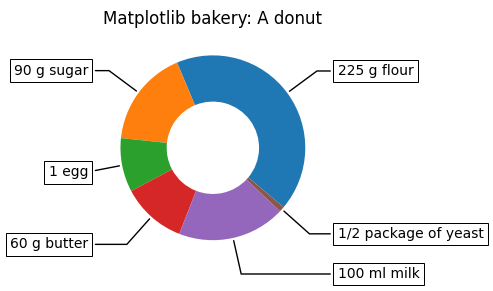

In [8]:
#####################################################
###    Referencia/Ejemplo para refinar gráfico    ###
#####################################################

#No afecta al programa
fig, ax = plt.subplots(figsize=(6, 3), subplot_kw=dict(aspect="equal"))

recipe = ["225 g flour",
          "90 g sugar",
          "1 egg",
          "60 g butter",
          "100 ml milk",
          "1/2 package of yeast"]

data = [225, 90, 50, 60, 100, 5]

wedges, texts = ax.pie(data, wedgeprops=dict(width=0.5), startangle=-40)

bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
kw = dict(arrowprops=dict(arrowstyle="-"),
          bbox=bbox_props, zorder=0, va="center")

for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = f"angle,angleA=0,angleB={ang}"
    kw["arrowprops"].update({"connectionstyle": connectionstyle})
    ax.annotate(recipe[i], xy=(x, y), xytext=(1.35*np.sign(x), 1.4*y),
                horizontalalignment=horizontalalignment, **kw)

ax.set_title("Matplotlib bakery: A donut")

plt.show()
#Fin Ref---------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [9]:
# =============================================================================
# Setteo Datos Regionales
# =============================================================================
                                  
# Usar BBDD?
RegNomb =   {'Antofagasta':             {'nom':'Región de Antofagasta',                  'nomCt':'Antofagasta'},
            'Araucanía':                {'nom':'Región de La Araucanía',                 'nomCt':'La Araucanía'},
            'Arica y Parinacota':       {'nom':'Región de Arica y Parinacota',           'nomCt':'Arica y Parinacota'},
            'Atacama':                  {'nom':'Región de Atacama',                      'nomCt':'Atacama'},
            'Aysén':                    {'nom':'Región de Aysén',                        'nomCt':'Aysén'},
            'Bío-Bío':                  {'nom':'Región del Bío-Bío',                     'nomCt':'el Bío-Bío'},
            'Coquimbo':                 {'nom':'Región de Coquimbo',                     'nomCt':'Coquimbo'},
            "Lib. Gral. Bdo. O'Higgins":{'nom':"Región de O'Higgins",                    'nomCt':"O'Higgins"},
            'Los Lagos':                {'nom':'Región de Los Lagos',                    'nomCt':'Los Lagos'},
            'Los Ríos':                 {'nom':'Región de Los Ríos',                     'nomCt':'Los Ríos'},
            'Magallanes y Antártica':   {'nom':'Región de Magallanes y la Antártica',    'nomCt':'Magallanes'},
            'Maule':                    {'nom':'Región del Maule',                       'nomCt':'el Maule'},
            'Metropolitana':            {'nom':'Región Metropolitana',                   'nomCt':'R. Metropolitana'},
            'Ñuble':                    {'nom':'Región del Ñuble',                       'nomCt':'el Ñuble'},
            'Tarapacá':                 {'nom':'Región de Tarapacá',                     'nomCt':'Tarapacá'},
            'Valparaíso':               {'nom':'Región de Valparaíso',                   'nomCt':'Valparaíso'}}


In [10]:
# =============================================================================
# Generar Iterador  con metricas Regionales
# =============================================================================

ListReg = pd.read_sql(con = conn_DW,  sql = qg.queryRegiones() )
ListReg = list(ListReg['Region'])
listReg = ListReg
QueryReg = pd.read_sql(con = conn_DW,  sql = qg.QueryReg())

#Iterando para que r tome el valor de todas las regiones disponibles
for r in ListReg:

    Reg = r
    #Reg = 'Antofagasta'
                                                      
    #Convencion: A = Año presente , B = Año pasado         
    RegFiltA = QueryReg.loc[(QueryReg['Region'] == Reg) & (QueryReg['Ano'] == AnoReg)]
    
    #Total transado por region en USD, CLP , CLF
    RegTotTransUSDA = RegFiltA['MONTOUSD'].sum()
    RegTotTransCLPA = RegFiltA['MONTOCLP'].sum()
    RegTotTransCLFA = RegFiltA['MONTOCLF'].sum()
    
    #Calculo de monto en CLF para calcular variacion con año pasado
    RegFiltB = QueryReg.loc[(QueryReg['Region'] == Reg) & (QueryReg['Ano'] == AnoRegM1)]
    RegTotTransCLFB = RegFiltB['MONTOCLF'].sum()
    
    #Calculo de variacion anual
    VarRegCLF = (RegTotTransCLFA - RegTotTransCLFB)/ RegTotTransCLFB *100
    
    #Total OC region
    RegTotOCA = RegFiltA['CantOC'].sum()
    
    #Calculando datos pyme
    RegFiltPymeA = RegFiltA.loc[RegFiltA['Tamano'].isin(['MiPyme'])]
    RegTotTransPymeCLFA = RegFiltPymeA['MONTOCLF'].sum()
    RegTotTransPymeCLPA = RegFiltPymeA['MONTOCLP'].sum()
    #Variacion transado pyme vs total transado
    VarTransPymeA = (RegTotTransPymeCLFA/RegTotTransCLFA)*100
    
    #Ranking top 3 instituciones con mayor monto transado
    RankFiltTransA = RegFiltA.groupby(by = 'NombreInstitucion')['MONTOCLP'].sum().sort_values(ascending = False).head(3)
    RankFiltTransA = RankFiltTransA.to_frame()
    RankFiltTransA= RankFiltTransA.reset_index()
    RankFiltTransA['NombreInstitucion'] = RankFiltTransA['NombreInstitucion'].str.upper()
    
    #Ranking top 3 Rubros con mayor monto transado
    QueryRegRubro = pd.read_sql(con = conn_DW,  sql = qg.queryRubroRegion() )
    RankRubroReg =  QueryRegRubro.loc[QueryRegRubro['Region'] == Reg]
    
    #Ranking top 3 OC de region para word
    RegRankOC = QTop10.loc[QTop10['Region'] == Reg]
    RegRankOC = RegRankOC[['NombreInstitucion','CodigoOC','MotivoCompra','NombreSucursal','USD_BRUTO']]
    
    #Version para word
    
    RegRankOCWord = RegRankOC.rename({'NombreInstitucion': 'Institución', 'CodigoOC': 'Código orden de compra'
                                      ,'MotivoCompra':'Motivo de la compra'
                                      ,'NombreSucursal': 'Proveedor','USD_BRUTO': 'Monto comprometido en US$'}, axis=1)
    
        
    #Cambiando formato de Dolares desde float a str
    RegRankOCWord['Monto comprometido en US$']  =  RegRankOCWord['Monto comprometido en US$'].astype(int) 
    RegRankOCWord['Monto comprometido en US$'] = RegRankOCWord['Monto comprometido en US$'].apply(itanum)  
    RegRankOCWord['Monto comprometido en US$']  = RegRankOCWord['Monto comprometido en US$'].astype(str)

In [11]:

############################################################################################
###    Definición funciones creación diccionarios y contexto para llenado de template    ###
############################################################################################


#Settea diccionario contexto regional
def setContextoReg(r):
    ctxt = {}
    ctxt.update(RegNomb[r])
    return ctxt


#Retorna diccionario con total transado de monto y OC por región
#(dataframe filtrado por región, moneda a usar)
def agregarTotalesRegion(df, mnd):
    nctxt = {}
    nctxt['totReg'+mnd]     = '$'+str(itanum(   df.loc[df['Año'] == AnoReg, 'Monto_Bruto_'+mnd].iloc[0]     ))
    nctxt['totRegOC']       =     str(itanum(   df.loc[df['Año'] == AnoReg, 'CantOC'].iloc[0]               ))
    nctxt['totReg'+mnd+'M'] = '$'+str(itanum(   df.loc[df['Año'] == AnoRegM1, 'Monto_Bruto_'+mnd].iloc[0]   ))
    nctxt['totRegOCM']      =     str(itanum(   df.loc[df['Año'] == AnoRegM1, 'CantOC'].iloc[0]             ))
    return nctxt


#Retorna diccionario con transado por rubro por región
#(dataframe filtrado por región, top, moneda a usar)
def agregarMontoRubrosRegion(df, top, mnd):

    #Seleccionar filas del top
    #en estos momentos entra un df con el top 3
    df = df.head(top)
    
    #Resetea index tabla, necesario para llenar correctamente Diccionario contexto
    df.reset_index(drop=True, inplace=True)

    #Agrega el top de sector,monto tranzado y pct (pct podría ser opcional)
    nctxt = {}
    for i,row in df.iterrows():
        nctxt['mtoRubReg'+str(i+1)]     = row['RubroN1']
        nctxt['mtoRubReg'+mnd+str(i+1)] = 'US$'+str(itanum(row['MONTO'+mnd]))
    return nctxt


#Retorna diccionario con Top especificado de Sectores por Monto transado y región, Moneda a especificar
#(dataframe filtrado por región, Tamaño top, moneda a usar)
def agregarMontoSectorRegion(df, top, mnd):

    #Seleccionar filas de la región y total de monto a usar
    totMnt = df['Monto_Bruto_'+mnd].sum()
    
    #Seleccionar filas del top
    df = df.head(top)
    #Resetea index tabla, necesario para llenar correctamente Diccionario contexto
    df.reset_index(drop=True, inplace=True)

    #Agrega el top de sector,monto tranzado y pct (pct podría ser opcional)
    nctxt = {}
    for i,row in df.iterrows():
        nctxt['mtoSecReg'+str(i+1)]     = row['Sector']
        nctxt['mtoSecReg'+mnd+str(i+1)] = '$'+str(itanum(row['Monto_Bruto_'+mnd]))
        nctxt['mtoSecRegPct'+str(i+1)]  = pctaje(100*row['Monto_Bruto_'+mnd]/totMnt)
    return nctxt


#Llama a creación de gráfico y retorna diccionario para agregarlo a template
#¿Pide moneda o dejamos default?
def agregarGrafMontoSectorRegion(df, mnd, titGraf):
    
    graf_torta(df['Monto_Bruto_'+mnd], df['Sector'], titGraf)
    #pedir docu como parametro?
    img = InlineImage(docu, titGraf+'.png',width=Inches(6))
    dctGrf = {'mtoSecRegGrf' : img}
    return dctGrf


def agregarCARegion(df, mnd): 
    nctxt = {}
    df0 = df.loc[df['Ano'] == AnoReg] #MONTOCLP_CAg  MONTOUSD_CAg  CantOC_CAg
    dfM = df.loc[df['Ano'] == AnoRegM1]
    return nctxt




#Importa datos especificados por solicitante para cada región, retorna un diccionario de diccionarios regionales con los datos
def impAdicionalesReg():
    addReg = pd.read_excel(io = 'datosAdicionales.xlsx') #requiere también openpyxl
    return addReg.set_index('region').to_dict('index')




In [12]:
###########################################################
###    Def parámetros indicadores y ejecuvión querys    ###
###########################################################


#Setea lista de regiones
#listReg = pd.read_sql(con = conn_DW,  sql = qg.queryRegiones() )
#listReg = list(listReg['Region'])


#Totales Regionales 2023 ¿y 2022?
TotReg = pd.read_sql(con = conn_DW,  sql = qg.queryTotalRegion() )
mndTotReg = 'CLP'


#Montos Rubros Regionales
RubReg = pd.read_sql(con = conn_DW,  sql = qg.queryRubroRegion() )
topRubReg = 3 #la query entrega el top 3, adaptar
mndRubReg = 'USD'

#Montos Sectores Regionales
# llamar query para dfSecReg = QSecReg.loc[QSecReg['region'] == r]
SecReg = pd.read_sql(con = conn_DW,  sql = qg.querySectorRegion() )
topSecReg = 4
mndSecReg = 'CLP'

#Montos Compra Agils Regional 2022 y 2023
CAReg = pd.read_sql(con = conn_DW,  sql = qg.queryCompraAgilRegion() )
print(CAReg)
mndCAReg = 'CLP'


     Ano                     Region  MONTOCLP_CAg  MONTOUSD_CAg  CantOC_CAg
0   2023                Antofagasta  6.961814e+09  8.564714e+06        9811
1   2022                Antofagasta  6.260722e+09  7.310428e+06        9067
2   2023                  Araucanía  2.542064e+10  3.126367e+07       34757
3   2022                  Araucanía  1.963787e+10  2.290707e+07       28948
4   2023         Arica y Parinacota  5.744237e+09  7.060077e+06        8210
5   2022         Arica y Parinacota  4.054672e+09  4.719849e+06        6033
6   2023                    Atacama  7.456477e+09  9.176114e+06       11763
7   2022                    Atacama  5.221718e+09  6.085403e+06        9150
8   2023                      Aysén  6.170559e+09  7.584409e+06        9462
9   2022                      Aysén  4.820661e+09  5.636189e+06        8162
10  2023                    Bío-Bío  2.878433e+10  3.542155e+07       42968
11  2022                    Bío-Bío  2.370149e+10  2.771492e+07       37474
12  2023    


Antofagasta
{'nom': 'Región de Antofagasta', 'nomCt': 'Antofagasta', 'totRegCLP': '$226.482', 'totRegOC': '26.087', 'totRegCLPM': '$147.191', 'totRegOCM': '23.403', 'mtoRubReg1': 'Obras', 'mtoRubRegUSD1': 'US$62.927.850', 'mtoRubReg2': 'Obras MINVU', 'mtoRubRegUSD2': 'US$25.665.374', 'mtoRubReg3': 'Servicios de construcción y mantenimiento', 'mtoRubRegUSD3': 'US$20.727.015', 'mtoSecReg1': 'Obras Públicas', 'mtoSecRegCLP1': '$84.044.175.663', 'mtoSecRegPct1': '37,1%', 'mtoSecReg2': 'Municipalidades', 'mtoSecRegCLP2': '$67.972.077.979', 'mtoSecRegPct2': '30,0%', 'mtoSecReg3': 'Salud', 'mtoSecRegCLP3': '$48.238.576.379', 'mtoSecRegPct3': '21,3%', 'mtoSecReg4': 'Gob. Central, Universidades', 'mtoSecRegCLP4': '$19.984.685.810', 'mtoSecRegPct4': '8,8%', 'mtoSecRegGrf': <docxtpl.inline_image.InlineImage object at 0x00000260AE98AF90>, 'fechaVisita': '8 de noviembre', 'asistentes': 5500, 'ano': '2023', 'anoAnt': '2022'}


PackageNotFoundError: Package not found at 'docxtpl.docx'

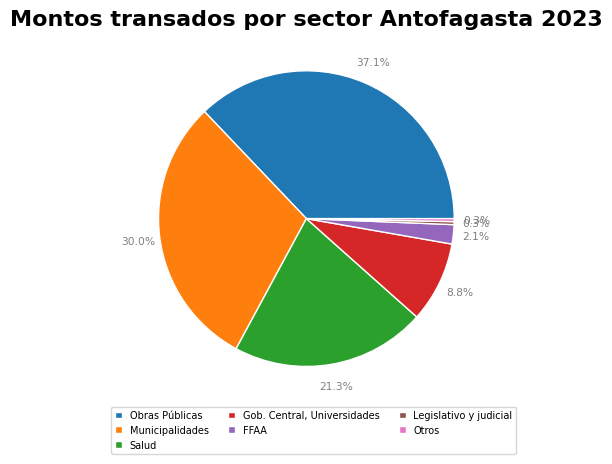

In [13]:
###################################################
###   Llenado diccionario/contexto y template   ###
###################################################


#Importar template
docu = DocxTemplate("docxtpl.docx")

#Settear diccionario nacional
contextoNac = {'ano' : str(AnoReg),
               'anoAnt' : str(AnoRegM1)}

#settear diccionario adicionales regionales
adicionalesReg = impAdicionalesReg()

#Iterador de regiones/documentos
for r in listReg:
    print('')
    print(r)
    contexto = setContextoReg(r)

    rTotReg = TotReg.loc[TotReg['Region'] == r]
    contexto.update(agregarTotalesRegion(rTotReg, mndTotReg))

    rRubReg = RubReg.loc[RubReg['Region'] == r]
    contexto.update(agregarMontoRubrosRegion(rRubReg, topRubReg, mndRubReg))

    rSecReg = SecReg.loc[SecReg['region'] == r]
    contexto.update(agregarMontoSectorRegion(rSecReg, topSecReg, mndSecReg))
    titGrafSecReg = contexto['nomCt'] + ' ' + str(AnoReg)
    contexto.update(agregarGrafMontoSectorRegion(rSecReg, mndSecReg, titGrafSecReg)) #remover grafico despues de renderizar

    contexto.update(adicionalesReg[r])

    contexto.update(contextoNac)
    
    print(contexto)
    docu.render(contexto)
    os.remove(titGrafSecReg +'.png')    #según cantidad de gráficos se podría iterar
    nomDocu = 'ProtoReporte ' + contexto['nomCt'] + ' ' + str(AnoReg)
    docu.save('reportes/'+nomDocu+'.docx')